In [ ]:
'''
【项目07】  城市餐饮店铺选址分析

1、从三个维度“口味”、“人均消费”、“性价比”对不同菜系进行比较，并筛选出可开店铺的餐饮类型
要求：
① 计算出三个维度的指标得分
② 评价方法：
   口味 → 得分越高越好
   性价比 → 得分越高越好
   人均消费 → 价格适中即可
③ 制作散点图，x轴为“人均消费”，y轴为“性价比得分”，点的大小为“口味得分”
   绘制柱状图，分别显示“口味得分”、“性价比得分”
   * 建议用bokeh做图
提示：
① 数据清洗，清除空值、为0的数据
② 口味指标计算方法 → 口味评分字段，按照餐饮类别分组算均值，再做标准化处理
③ 人均消费指标计算方法 → 人均消费字段，按照餐饮类别分组算均值，再做标准化处理
④ 性价比指标计算方法 → 性价比 = （口味 + 环境 + 服务）/人均消费，按照餐饮类别分组算均值，再做标准化处理
⑤ 数据计算之前，检查一下数据分布，去除异常值（以外限为标准）
   * 这里排除了高端奢侈餐饮的数据干扰
⑥ 注意，这里先分别计算三个指标，再合并数据（merge）作图，目的是指标之间的噪音数据不相互影响

2、选择一个餐饮类型，在qgis中做将上海划分成格网空间，结合python辅助做空间指标评价，得到餐饮选址位置
* 课程这里以“素菜馆为例”
课程数据
① net_population.shp → 投影坐标系，上海1km²格网内的人口密度数据
② road.shp → 投影坐标西，上海道路数据
要求：
① 通过空间分析，分别计算每个格网内的几个指标：人口密度指标、道路密度指标、餐饮热度指标、同类竞品指标
② 评价方法：
   人口密度指标 → 得分越高越好
   道路密度指标 → 得分越高越好
   餐饮热度指标 → 得分越高越好
   同类竞品指标 → 得分越低越好
   综合指标 = 人口密度指标*0.4 + 餐饮热度指标*0.3 + 道路密度指标*0.2 +同类竞品指标*0.1
③ 最后得到较好选址的网格位置的中心坐标，以及所属区域
   * 可以用bokeh制作散点图
提示：
① 道路密度指标计算方法 → 网格内道路长度
② 餐饮热度指标计算方法 → 网格内餐饮poi计数
③ 同类竞品指标计算方法 → 网格内素菜馆poi计数
④ 餐饮poi数据记得投影
⑤ 可以以“net_population.shp”为网格基础数据，做空间统计
⑥ 在qgis做空间统计之后，网格数据导出点数据，投影成wgs84地理坐标系，导出excel数据，在python做指标标准化等
⑦ 在bokeh中做散点图时，注意添加一个size字段，通过最终评分来赋值
⑧ 在bokeh中做散点图时，可以给TOP10的点用颜色区分

'''

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import warnings
warnings.filterwarnings('ignore') 
# 不发出警告

from bokeh.io import output_notebook
output_notebook()
# 导入notebook绘图模块

from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource
# 导入图表绘制、图标展示模块
# 导入ColumnDataSource模块

Loading BokehJS ...

In [4]:
df1 = pd.read_excel('上海餐饮数据.xlsx')
df1.head()

,类别,行政区,点评数,口味,环境,服务,人均消费,城市,Lng,Lat
0,烧烤,浦东新区,176,8.0,8.6,7.9,124,上海市,121.967860,30.884477
1,美食,闵行区,2,6.1,6.5,6.3,0,上海市,121.967781,30.883818
2,粤菜,浦东新区,141,6.7,7.2,6.6,141,上海市,121.933142,30.893224
3,海鲜,浦东新区,76,7.2,7.2,7.3,148,上海市,121.926062,30.899868
4,烧烤,浦东新区,600,7.2,7.6,7.0,143,上海市,121.925877,30.901100


In [6]:
df1_len = len(df1) #获取 dataFrame 的数据量
df1_columns = df1.columns.tolist 
print('数据量为%d条，%s' %(df1_len, df1_columns))

数据量为96398条，<bound method IndexOpsMixin.tolist of Index(['类别', '行政区', '点评数', '口味', '环境', '服务', '人均消费', '城市', 'Lng', 'Lat'], dtype='object')>


In [12]:
data1 = df1[['类别','口味','环境','服务','人均消费']]
data1.dropna(inplace=True)
print('去除空值之后的数据量：%d' %(len(data1)))
data2 = data1[(data1['口味']>0) & (data1['人均消费']>0)] #从表中可以看出，口味评分=0的环境和服务评分也是0
print('剔除评分为0之后的数据量：%d' %len(data2))

去除空值之后的数据量：96258
剔除评分为0之后的数据量：54889


In [14]:
#计算性价比
data2['性价比'] = (data2['口味'] + data2['环境'] + data2['服务'])/data2['人均消费']
data2.head()

,类别,口味,环境,服务,人均消费,性价比
0,烧烤,8.0,8.6,7.9,124,0.197581
2,粤菜,6.7,7.2,6.6,141,0.145390
3,海鲜,7.2,7.2,7.3,148,0.146622
4,烧烤,7.2,7.6,7.0,143,0.152448
5,本菜,8.2,8.9,8.4,66,0.386364


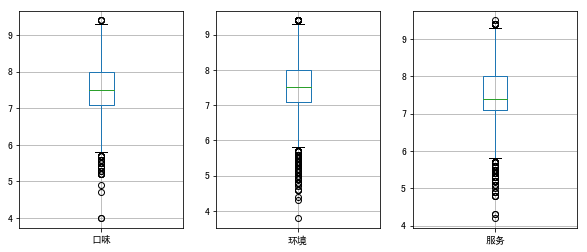

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
data2.boxplot(column=['口味'], ax = axes[0])
data2.boxplot(column=['环境'], ax = axes[1])
data2.boxplot(column=['服务'], ax = axes[2])